# 학습목표
   - 단일 변수 1시간 예측 (Dense, LSTM)
   - 단일 변수 3시간 예측 (GRU)
   - 다변수 1시간 예측 (LSTM)

# 단일변수 시계열 예측 (1시간)
- 데이터셋
  - GEFCom2014 예측 대회에서 사용된 시계열
  - 2012년과 2014년 사이의 3년간 시간별 전기 부하 및 온도 값으로 구성
  - 컬럼 : timestamp(날짜시간), load(부하), temp(온도)

- 순서 : 시계열을 학습이 가능한 형태로 변환
  - 데이터 로드 (소수점 2째자리까지만 표시)
  - temp 컬럼은 삭제
  - timestamp 컬럼을 datetime 형태로 변환
  - timestamp 컬럼을 인덱스로 사용  
  - 훈련, 검증, 테스트 셋으로 분리
  - 데이터 시각화
  - 스케일링
  - 라벨데이터를 저장
  - 훈련가능한 특성 데이터로 변환 (설정한 시간만큼씩 데이터를 잘라서 특성데이터로 저장)
  - 결측치 삭제
  - 특성데이터와 라벨데이터 분리
  - 신경망 설계 및 학습
  - 1시간 이후의 부하를 예측
  - 성능평가 (오차 계산)
  - 예측 결과 시각화



# 데이터 로드

In [5]:
python.exe -m pip install --upgrade pip

SyntaxError: invalid syntax (842801469.py, line 1)

In [2]:
import pymysql
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# DB 연결 설정 (본인의 DB 정보로 수정)
conn = pymysql.connect(
    host='localhost',
    user='dbuser',
    password='1234',
    db='project',
    charset='utf8'
)

# 데이터 가져오기
try:
    query = 'SELECT * FROM NAJU_WEATHER_TB'  # 예시: NAJU_WEATHER_TB 테이블에서 데이터 전체를 가져옴
    df = pd.read_sql(query, conn)
finally:
    conn.close()

ModuleNotFoundError: No module named 'pymysql'

/content/drive/MyDrive/Colab Notebooks/인공지능강의/project


In [ ]:
# 데이터 가져오기
import pandas as pd
import numpy as np

# pandas 소수점을 2자리까지만 설정
pd.options.display.float_format = '{:.2f}'.format

# numpy 소수점을 2자리까지만 설정
np.set_printoptions(precision=2)

energy = pd.read_csv('./data/energy.csv')
energy.head()

,timestamp,load,temp
0,2012-01-01 00:00:00,2698.00,32.00
1,2012-01-01 01:00:00,2558.00,32.67
2,2012-01-01 02:00:00,2444.00,30.00
3,2012-01-01 03:00:00,2402.00,31.00
4,2012-01-01 04:00:00,2403.00,32.00


- temp 컬럼 삭제

In [ ]:
del energy['temp']
energy.head()

,timestamp,load
0,2012-01-01 00:00:00,2698.00
1,2012-01-01 01:00:00,2558.00
2,2012-01-01 02:00:00,2444.00
3,2012-01-01 03:00:00,2402.00
4,2012-01-01 04:00:00,2403.00


In [ ]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  26304 non-null  object 
 1   load       26304 non-null  float64
dtypes: float64(1), object(1)
memory usage: 411.1+ KB


- timestamp 컬럼을 시간연산을 하기 위해 datetime 타입으로 변환

In [ ]:
energy['timestamp'] = pd.to_datetime(energy['timestamp'])
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  26304 non-null  datetime64[ns]
 1   load       26304 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 411.1 KB


In [ ]:
energy.head()

,timestamp,load
0,2012-01-01 00:00:00,2698.00
1,2012-01-01 01:00:00,2558.00
2,2012-01-01 02:00:00,2444.00
3,2012-01-01 03:00:00,2402.00
4,2012-01-01 04:00:00,2403.00


- timstamp 컬럼을 인덱스 컬럼으로 사용

In [ ]:
energy = energy.set_index('timestamp')
energy.head()

,load
timestamp,
2012-01-01 00:00:00,2698.00
2012-01-01 01:00:00,2558.00
2012-01-01 02:00:00,2444.00
2012-01-01 03:00:00,2402.00
2012-01-01 04:00:00,2403.00


# 훈련, 검증, 테스트 데이터로 분리
  - 훈련 : 학습용 데이터 (특성 + 라벨)
  - 검증 : 학습된 모델을 평가 (과적합 확인) (특성 + 라벨)
  - 테스트 : 실제 데이터로 예측 (특성만 있음)

  - 데이터 분리 기준
    - 훈련 : 2012년 1월 1일 ~ 2014년 8월 31일
    - 검증 : 2014년 9월 1일 ~ 2014년 10월 31일
    - 테스트 : 2014년 11월 1일 ~ 2014년 12월 31일

In [ ]:
# 분리 기준
# 검증데이터 시작일
valid_start_dt = '2014-09-01 00:00:00'
# 테스트데이터의 시작일
test_start_dt = '2014-11-01 00:00:00'

# 훈련 데이터 분리
# 검증데이터의 시작일보다 이전 일자를 훈련데이터로 설정
train = energy[energy.index < valid_start_dt]
display(train)

,load
timestamp,
2012-01-01 00:00:00,2698.00
2012-01-01 01:00:00,2558.00
2012-01-01 02:00:00,2444.00
2012-01-01 03:00:00,2402.00
2012-01-01 04:00:00,2403.00
...,...
2014-08-31 19:00:00,3969.00
2014-08-31 20:00:00,3869.00
2014-08-31 21:00:00,3643.00


In [ ]:
# 검증 데이터 분리
valid = energy[(energy.index >= valid_start_dt) & \
               (energy.index < test_start_dt)]
display(valid)

,load
timestamp,
2014-09-01 00:00:00,2886.00
2014-09-01 01:00:00,2768.00
2014-09-01 02:00:00,2699.00
2014-09-01 03:00:00,2681.00
2014-09-01 04:00:00,2690.00
...,...
2014-10-31 19:00:00,3374.00
2014-10-31 20:00:00,3315.00
2014-10-31 21:00:00,3142.00


In [ ]:
# 테스트 데이터 분리
test = energy[energy.index >= test_start_dt]
display(test)

,load
timestamp,
2014-11-01 00:00:00,2514.00
2014-11-01 01:00:00,2434.00
2014-11-01 02:00:00,2390.00
2014-11-01 03:00:00,2382.00
2014-11-01 04:00:00,2419.00
...,...
2014-12-31 19:00:00,4012.00
2014-12-31 20:00:00,3856.00
2014-12-31 21:00:00,3671.00


- 훈련, 검증, 테스트 데이터 시각화

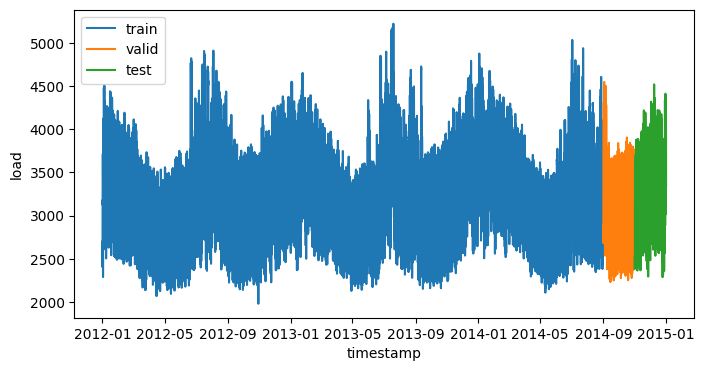

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(train, label='train')
plt.plot(valid, label='valid')
plt.plot(test, label='test')
plt.xlabel("timestamp")
plt.ylabel("load")
plt.legend()
plt.show()

- 값들의 범위를 0-1 사이로 스케일링
  - 값의 최대/최소 값을 차이를 줄여서 성능 향상 (오차크기 감소)
  - 여러 개의 특성이 다른 범위의 값을 갖는 경우 라벨이 큰 값에 영향을 받는 것을 방지

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일링을 하기위해서 최대와 최소값을 분석
# 분석 훈련데이터로만 수행
scaler.fit(train)

# 검증과 테스트 데이터를 훈련데이터의 분석 결과를 이용해서 스케일링을 해야 함
train['load'] = scaler.transform(train)
valid['load'] = scaler.transform(valid)
test['load'] = scaler.transform(test)

train.head()

,load
timestamp,
2012-01-01 00:00:00,0.22
2012-01-01 01:00:00,0.18
2012-01-01 02:00:00,0.14
2012-01-01 03:00:00,0.13
2012-01-01 04:00:00,0.13


In [ ]:
# 특성 데이터의 수
T = 6
# 라벨 데이터의 수
HORISON =  1

  - 라벨데이터를 저장

In [ ]:
train_shifted = train.copy()

# 라벨값은 다음 시간의 데이터로 설정
# shift(-1, freq='H') : 시간을 이전으로 1 H(시간) 만큼 이동
train_shifted['y_t+1'] = train_shifted['load'].shift(-HORISON, freq='H')
train_shifted.head()

,load,y_t+1
timestamp,,
2012-01-01 00:00:00,0.22,0.18
2012-01-01 01:00:00,0.18,0.14
2012-01-01 02:00:00,0.14,0.13
2012-01-01 03:00:00,0.13,0.13
2012-01-01 04:00:00,0.13,0.15


# 훈련/검증/테스트 데이터에 학습 가능한 데이터 형태로 변환

- 예측을 위해 사용할 특성 데이터 : 6시간 (T=6), t-5 ~ t -> 실험을 통해서 결정

- 라벨의 수 : 몇 시간 이후 것들을 예측할 것인지 설정 (1시간 이후, HORISON=1)

<center><img src="https://arome1004.cafe24.com/images/time_series/lecture_image/one_step_forecast.png" width=60%>
</center>


  - 훈련가능한 특성 데이터로 변환 (설정한 시간만큼씩 데이터를 잘라서 특성데이터로 저장)

In [ ]:
for t in range(1, T+1):
    train_shifted['t-{}'.format(T-t)] = train_shifted['load'].shift(T-t, freq="H")

train_shifted.head(10)

,load,y_t+1,t-5,t-4,t-3,t-2,t-1,t-0
timestamp,,,,,,,,
2012-01-01 00:00:00,0.22,0.18,NaN,NaN,NaN,NaN,NaN,0.22
2012-01-01 01:00:00,0.18,0.14,NaN,NaN,NaN,NaN,0.22,0.18
2012-01-01 02:00:00,0.14,0.13,NaN,NaN,NaN,0.22,0.18,0.14
2012-01-01 03:00:00,0.13,0.13,NaN,NaN,0.22,0.18,0.14,0.13
2012-01-01 04:00:00,0.13,0.15,NaN,0.22,0.18,0.14,0.13,0.13
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29


- 결측치 제거

In [ ]:
# how="any" : 하나의 컬럼이라도 결측치가 있는 데이터를 삭제
train_shifted = train_shifted.dropna(how="any")
train_shifted.head(10)

,load,y_t+1,t-5,t-4,t-3,t-2,t-1,t-0
timestamp,,,,,,,,
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35
2012-01-01 10:00:00,0.37,0.37,0.15,0.18,0.23,0.29,0.35,0.37
2012-01-01 11:00:00,0.37,0.37,0.18,0.23,0.29,0.35,0.37,0.37
2012-01-01 12:00:00,0.37,0.36,0.23,0.29,0.35,0.37,0.37,0.37
2012-01-01 13:00:00,0.36,0.35,0.29,0.35,0.37,0.37,0.37,0.36


- 검증데이터를 라벨과 특성데이터 형태로 만들기

In [ ]:
valid_shifted = valid.copy()

valid_shifted['y_t+1'] = valid_shifted['load'].shift(-HORISON, freq='H')

for t in range(1, T+1):
    valid_shifted['t-{}'.format(T-t)] = valid_shifted['load'].shift(T-t, freq="H")

valid_shifted = valid_shifted.dropna(how="any")

valid_shifted.head()

,load,y_t+1,t-5,t-4,t-3,t-2,t-1,t-0
timestamp,,,,,,,,
2014-09-01 05:00:00,0.24,0.28,0.28,0.24,0.22,0.22,0.22,0.24
2014-09-01 06:00:00,0.28,0.34,0.24,0.22,0.22,0.22,0.24,0.28
2014-09-01 07:00:00,0.34,0.44,0.22,0.22,0.22,0.24,0.28,0.34
2014-09-01 08:00:00,0.44,0.54,0.22,0.22,0.24,0.28,0.34,0.44
2014-09-01 09:00:00,0.54,0.60,0.22,0.24,0.28,0.34,0.44,0.54


- 테스트 데이터를 라벨과 특성데이터 형태로 만들기

In [ ]:
test_shifted = test.copy()

test_shifted['y_t+1'] = test_shifted['load'].shift(-HORISON, freq='H')

for t in range(1, T+1):
    test_shifted['t-{}'.format(T-t)] = test_shifted['load'].shift(T-t, freq="H")

test_shifted = test_shifted.dropna(how="any")

test_shifted.head()

,load,y_t+1,t-5,t-4,t-3,t-2,t-1,t-0
timestamp,,,,,,,,
2014-11-01 05:00:00,0.17,0.23,0.16,0.14,0.13,0.12,0.14,0.17
2014-11-01 06:00:00,0.23,0.31,0.14,0.13,0.12,0.14,0.17,0.23
2014-11-01 07:00:00,0.31,0.37,0.13,0.12,0.14,0.17,0.23,0.31
2014-11-01 08:00:00,0.37,0.42,0.12,0.14,0.17,0.23,0.31,0.37
2014-11-01 09:00:00,0.42,0.45,0.14,0.17,0.23,0.31,0.37,0.42


- 특성데이터와 라벨데이터 분리

In [ ]:
X_train = train_shift.iloc[:, 2:]
y_train = train_shift["y_t+1"]

X_valid = valid_shift.iloc[:, 2:]
y_valid = valid_shift["y_t+1"]

X_test = test_shift.iloc[:, 2:]
y_test = test_shift["y_t+1"]

In [ ]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((23370, 6), (23370,), (1458, 6), (1458,), (1458, 6), (1458,))

- 신경망 설계 및 학습
  - 6개의 입력, 1개의 출력을 갖는 신경망
  - 은닉층의 퍼셉트론 수는 5개

  <center><img src="https://arome1004.cafe24.com/images/time_series/lecture_image/ff_one_step_univariate.png" width=60%>
</center>

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model1 = Sequential()
model1.add(Dense(5, input_shape=(T,), activation='relu'))

model1.add(Dense(1))

In [ ]:
model1.compile(loss="mse", optimizer="adam")

- EarlyStopping (학습중단), ModelCheckPoint (베스트모델 저장)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# monitor='loss', mode='min' : loss가 최소인 경우에 학습 중단
# patience=50 : 학습이 더 좋아지지 않더라도 50번 epoch를 더 수행
es = EarlyStopping(monitor='loss', mode='min', patience=50)
# save_best_only=True : 더 나아진 모델만 저장
mc = ModelCheckpoint('./model/series_model_{epoch:02d}_{loss:.3f}_{val_loss:.3f}.h5',
                     monitor='loss', mode='min',
                     save_best_only=True)

h1 = model1.fit(X_train, y_train, epochs=50, batch_size=32,
                validation_data=(X_valid, y_valid),
                callbacks=[es, mc])

Epoch 1/50
731/731 [==============================] - 2s 2ms/step - loss: 0.0683 - val_loss: 0.0072
Epoch 2/50
101/731 [===>..........................] - ETA: 0s - loss: 0.0073

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


731/731 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 3/50
731/731 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 4/50
731/731 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 5/50
731/731 [==============================] - 2s 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/50
731/731 [==============================] - 2s 2ms/step - loss: 0.0011 - val_loss: 8.3852e-04
Epoch 7/50
731/731 [==============================] - 1s 2ms/step - loss: 8.6763e-04 - val_loss: 6.7394e-04
Epoch 8/50
731/731 [==============================] - 1s 2ms/step - loss: 7.3525e-04 - val_loss: 5.7191e-04
Epoch 9/50
731/731 [==============================] - 1s 2ms/step - loss: 6.8175e-04 - val_loss: 5.2118e-04
Epoch 10/50
731/731 [==============================] - 2s 3ms/step - loss: 6.6161e-04 - val_loss: 5.0448e-04
Epoch 11/50
731/731 [==============================] - 1s 2ms/step - loss:

- 학습결과 시각화

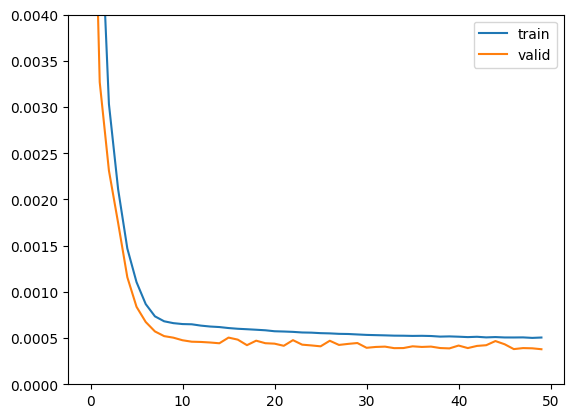

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h1.history['loss'], label='train')
plt.plot(h1.history['val_loss'], label='valid')
plt.ylim(0, 0.004)
plt.legend()
plt.show()

- 1시간 이후의 부하를 예측

- 베스트 모델 가져오기

In [ ]:
model1.load_weights("./model/series_model_49_0.001_0.001.h5")

In [ ]:
# 테스트 데이터를 이용해서 load를 예측
pred = model1.predict(X_test)

46/46 [==============================] - 0s 2ms/step


In [ ]:
# 예측한 결과를 DataFrame으로 변환
eval_df = pd.DataFrame(pred, columns=["pred_t+1"])

eval_df.head()

,pred_t+1
0,0.21
1,0.29
2,0.37
3,0.42
4,0.46


In [ ]:
# timestamp를 인덱스로 추가
eval_df["timestamp"] = test_shifted.index

eval_df.head()

,pred_t+1,timestamp
0,0.21,2014-11-01 05:00:00
1,0.29,2014-11-01 06:00:00
2,0.37,2014-11-01 07:00:00
3,0.42,2014-11-01 08:00:00
4,0.46,2014-11-01 09:00:00


In [ ]:
# 컬럼이 순서를 timestamp, pred_t+1 순으로 변경
eval_df = eval_df[["timestamp", "pred_t+1"]]

eval_df.head()

,timestamp,pred_t+1
0,2014-11-01 05:00:00,0.21
1,2014-11-01 06:00:00,0.29
2,2014-11-01 07:00:00,0.37
3,2014-11-01 08:00:00,0.42
4,2014-11-01 09:00:00,0.46


In [ ]:
# y_test 컬럼을 만들어서 오른쪽에 y_test 값을 붙임
# y_test = [1, 2, 3, 4, 5, 6] -> 열 데이터 -> 행 데이터 -> transpose() 또는 .T
# ravel() : 다차원 데이터 -> 1차원 데이터
eval_df["y_test"] = np.transpose(y_test).ravel()
#eval_df = pd.merge(eval_df, y_test, on="timestamp")

eval_df.head(5)

<ipython-input-32-32c041061e03>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df["y_test"] = np.transpose(y_test).ravel()


,timestamp,pred_t+1,y_test
0,2014-11-01 05:00:00,0.21,0.23
1,2014-11-01 06:00:00,0.29,0.31
2,2014-11-01 07:00:00,0.37,0.37
3,2014-11-01 08:00:00,0.42,0.42
4,2014-11-01 09:00:00,0.46,0.45


In [ ]:
# inverse_transform() : 스케일링된 load 값을 원래 값으로 복원
eval_df[["pred_t+1", "y_test"]] = \
          scaler.inverse_transform(eval_df[["pred_t+1", "y_test"]])

eval_df.head()

<ipython-input-33-ca4f4b4227a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[["pred_t+1", "y_test"]] = \


,timestamp,pred_t+1,y_test
0,2014-11-01 05:00:00,2656.38,2714.00
1,2014-11-01 06:00:00,2918.47,2970.00
2,2014-11-01 07:00:00,3194.63,3189.00
3,2014-11-01 08:00:00,3340.40,3356.00
4,2014-11-01 09:00:00,3461.99,3436.00


- 성능평가 (오차 계산)

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

rmse(eval_df["pred_t+1"], eval_df["y_test"])

81.15756508672092

- 예측 결과 시각화
  - 테스트 데이터의 첫번째 주만 시각화

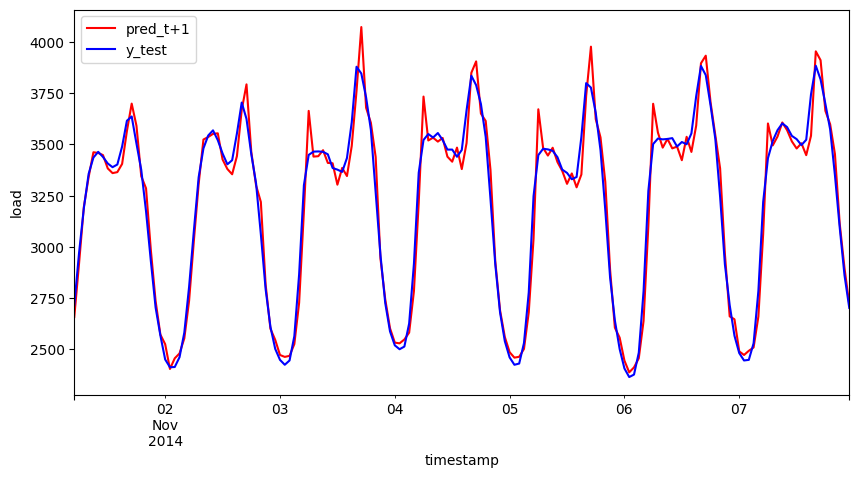

In [ ]:
eval_df[eval_df["timestamp"] < "2014-11-08"].plot(x="timestamp",
                                                  y=["pred_t+1", "y_test"],
                                                  style=["r", "b"],
                                                  figsize=(10, 5))
plt.xlabel("timestamp")
plt.ylabel("load")
plt.show()

# LSTM을 이용한 단일변수/Single Step 예측

<center><img src="https://arome1004.cafe24.com/images/time_series/lecture_image/one_step_univariate.png" width=60%>
</center>

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

model2 = Sequential()
model2.add(LSTM(5, input_shape=(T, 1)))
model2.add(Dense(1))

model2.compile(loss="mse", optimizer="adam")

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', patience=50)
mc = ModelCheckpoint('./model/lstm_model_{epoch:02d}_{loss:.3f}_{val_loss:.3f}.h5',
                     monitor='loss', mode='min',
                     save_best_only=True)

h2 = model2.fit(X_train, y_train, epochs=50, batch_size=32,
                validation_data=(X_valid, y_valid),
                callbacks=[es, mc])

Epoch 1/50
731/731 [==============================] - 6s 6ms/step - loss: 0.0182 - val_loss: 0.0076
Epoch 2/50
 15/731 [..............................] - ETA: 5s - loss: 0.0079

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


731/731 [==============================] - 4s 6ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 3/50
731/731 [==============================] - 3s 5ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 4/50
731/731 [==============================] - 3s 4ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 5/50
731/731 [==============================] - 5s 6ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 6/50
731/731 [==============================] - 3s 5ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 7/50
731/731 [==============================] - 3s 4ms/step - loss: 9.3113e-04 - val_loss: 8.5585e-04
Epoch 8/50
731/731 [==============================] - 3s 5ms/step - loss: 7.0970e-04 - val_loss: 5.8611e-04
Epoch 9/50
731/731 [==============================] - 5s 6ms/step - loss: 6.0481e-04 - val_loss: 5.7250e-04
Epoch 10/50
731/731 [==============================] - 4s 6ms/step - loss: 5.7800e-04 - val_loss: 5.4448e-04
Epoch 11/50
731/731 [==============================] - 4s 6ms/step - loss: 5.7

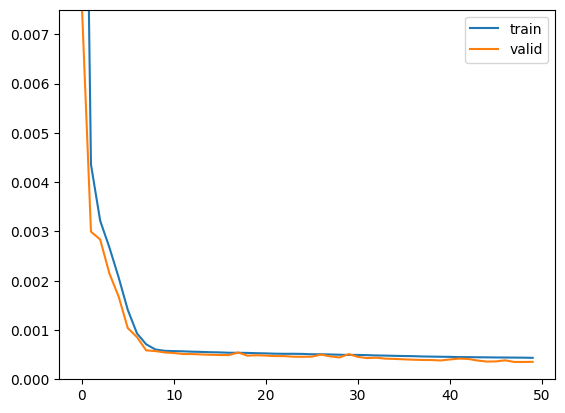

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h2.history['loss'], label='train')
plt.plot(h2.history['val_loss'], label='valid')
plt.ylim(0, 0.0075)
plt.legend()
plt.show()

- 예측

In [ ]:
model2.load_weights("./model/lstm_model_50_0.000_0.000.h5")

In [ ]:
pred = model2.predict(X_test)

46/46 [==============================] - 1s 3ms/step


In [ ]:
pred

array([[0.23],
       [0.31],
       [0.37],
       ...,
       [0.54],
       [0.46],
       [0.43]], dtype=float32)

In [ ]:
eval_df = pd.DataFrame(pred, columns=["pred_t+1"])

eval_df["timestamp"] = test_shifted.index

eval_df.head()

,pred_t+1,timestamp
0,0.23,2014-11-01 05:00:00
1,0.31,2014-11-01 06:00:00
2,0.37,2014-11-01 07:00:00
3,0.41,2014-11-01 08:00:00
4,0.46,2014-11-01 09:00:00


In [ ]:
# 컬럼 순서 변경
eval_df = eval_df[["timestamp", "pred_t+1"]]

eval_df.head()

In [ ]:
# y_test 추가
eval_df["actual"] = np.transpose(y_test).ravel()

eval_df.head()

,timestamp,pred_t+1,actual
0,2014-11-01 05:00:00,0.23,0.23
1,2014-11-01 06:00:00,0.31,0.31
2,2014-11-01 07:00:00,0.37,0.37
3,2014-11-01 08:00:00,0.41,0.42
4,2014-11-01 09:00:00,0.46,0.45


In [ ]:
# 역스케일링으로 원래값을 복원
eval_df[["pred_t+1", "actual"]] = \
          scaler.inverse_transform(eval_df[["pred_t+1", "actual"]])

eval_df.head()

,timestamp,pred_t+1,actual
0,2014-11-01 05:00:00,2722.15,2714.00
1,2014-11-01 06:00:00,2977.74,2970.00
2,2014-11-01 07:00:00,3187.99,3189.00
3,2014-11-01 08:00:00,3321.97,3356.00
4,2014-11-01 09:00:00,3477.93,3436.00


In [ ]:
# mse로 평가
rmse(eval_df["pred_t+1"], eval_df["actual"])

65.47851783421729

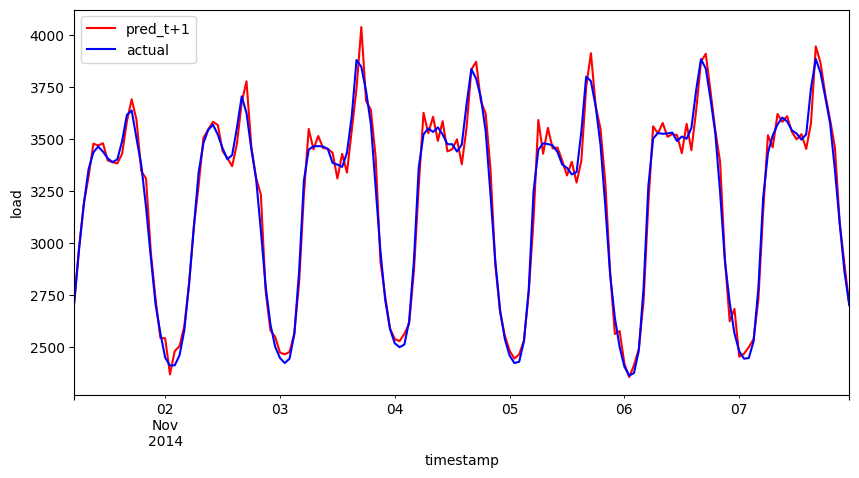

In [ ]:
# 시각화
eval_df[eval_df["timestamp"] < "2014-11-08"].plot(x="timestamp",
                                                  y=["pred_t+1", "actual"],
                                                  style=["r", "b"],
                                                  figsize=(10, 5))
plt.xlabel("timestamp")
plt.ylabel("load")
plt.show()

# LSTM을 이용한 단일변수/Multi Step 예측
  - 1시간, 2시간, 3시간 이후의 load 값을 예측
  - y_t+1, y_t+2, y_t+3 컴럼에 시간을 -1, -2, -3 시프트해서 저장

In [ ]:
train_shifted = train.copy()

train_shifted["y_t+1"] = train_shifted["load"].shift(-1, freq="H")
train_shifted["y_t+2"] = train_shifted["load"].shift(-2, freq="H")
train_shifted["y_t+3"] = train_shifted["load"].shift(-3, freq="H")

train_shifted.head()

,load,y_t+1,y_t+2,y_t+3
timestamp,,,,
2012-01-01 00:00:00,0.22,0.18,0.14,0.13
2012-01-01 01:00:00,0.18,0.14,0.13,0.13
2012-01-01 02:00:00,0.14,0.13,0.13,0.15
2012-01-01 03:00:00,0.13,0.13,0.15,0.18
2012-01-01 04:00:00,0.13,0.15,0.18,0.23


- 특성 데이터 6개 추가

In [ ]:
for t in range(1, T+1) :
    train_shifted["load_t-" + str(T-t)] = train_shifted["load"].shift(T-t, freq="H")

# 결측치 제거
train_shifted = train_shifted.dropna(how="any")
train_shifted.head()

,load,y_t+1,y_t+2,y_t+3,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,,,
2012-01-01 05:00:00,0.15,0.18,0.23,0.29,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.29,0.35,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.35,0.37,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.37,0.37,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.37,0.37,0.13,0.15,0.18,0.23,0.29,0.35


- 특성, 라벨 데이터 분리

In [ ]:
y_train = train_shifted.iloc[:, 1:4]
X_train = train_shifted.iloc[:, 4:]

X_train.shape, y_train.shape

((23368, 6), (23368, 3))

- 검증데이터 분리

In [ ]:
valid_shifted = valid.copy()
valid_shifted["y_t+1"] = valid_shifted["load"].shift(-1, freq="H")
valid_shifted["y_t+2"] = valid_shifted["load"].shift(-2, freq="H")
valid_shifted["y_t+3"] = valid_shifted["load"].shift(-3, freq="H")

for t in range(1, T+1) :
  valid_shifted["load_t-" + str(T-t)] = valid_shifted["load"].shift(T-t, freq="H")

valid_shifted = valid_shifted.dropna(how="any")

y_valid = valid_shifted.iloc[:, 1:4]
X_valid = valid_shifted.iloc[:, 4:]

X_valid.shape, y_valid.shape

((1456, 6), (1456, 3))

-  테스트 데이터 분리

In [ ]:
test_shifted = test.copy()
test_shifted["y_t+1"] = test_shifted["load"].shift(-1, freq="H")
test_shifted["y_t+2"] = test_shifted["load"].shift(-2, freq="H")
test_shifted["y_t+3"] = test_shifted["load"].shift(-3, freq="H")

for t in range(1, T+1) :
  test_shifted["load_t-" + str(T-t)] = test_shifted["load"].shift(T-t, freq="H")

test_shifted = test_shifted.dropna(how="any")

y_test = test_shifted.iloc[:, 1:4]
X_test = test_shifted.iloc[:, 4:]

X_test.shape, y_test.shape

((1456, 6), (1456, 3))

- 신경망 설계
<center><img src="https://arome1004.cafe24.com/images/time_series/lecture_image/multi_step_vector_output.png" width=60%>
</center>

In [ ]:
model3 = Sequential()
model3.add(LSTM(5, input_shape=(T, 1)))
model3.add(Dense(3))

model3.compile(loss="mse", optimizer="adam")

In [ ]:
et = EarlyStopping(monitor="loss", mode="min", patience=10)
mc = ModelCheckpoint("./model/lstm2_model_{epoch:02d}_{loss:.3f}_{val_loss:.3f}.h5",
                     monitor="loss", mode="min",
                     save_best_only=True)

h3 = model3.fit(X_train, y_train, epochs=50, batch_size=32,
                validation_data=(X_valid, y_valid),
                callbacks=[et, mc])

Epoch 1/50
731/731 [==============================] - 4s 5ms/step - loss: 0.0160 - val_loss: 0.0126
Epoch 2/50
 17/731 [..............................] - ETA: 4s - loss: 0.0137

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


731/731 [==============================] - 4s 6ms/step - loss: 0.0109 - val_loss: 0.0089
Epoch 3/50
731/731 [==============================] - 4s 5ms/step - loss: 0.0072 - val_loss: 0.0057
Epoch 4/50
731/731 [==============================] - 3s 5ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 5/50
731/731 [==============================] - 5s 6ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 6/50
731/731 [==============================] - 4s 5ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 7/50
731/731 [==============================] - 4s 5ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 8/50
731/731 [==============================] - 4s 5ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 9/50
731/731 [==============================] - 5s 6ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 10/50
731/731 [==============================] - 4s 5ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 11/50
731/731 [==============================] - 4s 5ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 12/

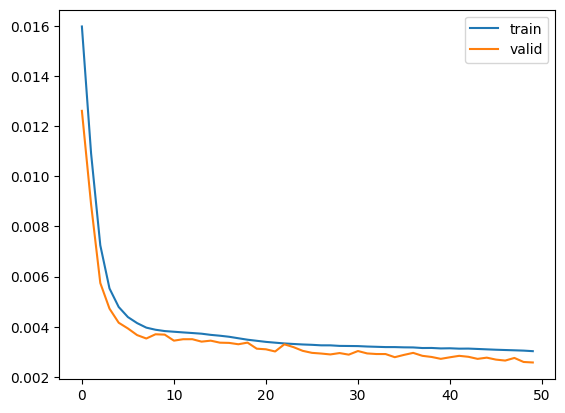

In [ ]:
# 시각화
plt.plot(h3.history["loss"], label="train")
plt.plot(h3.history["val_loss"], label="valid")
plt.legend()
plt.show()

In [ ]:
# 모델 가져오기
model3.load_weights("./model/lstm2_model_50_0.003_0.003.h5")

- 예측

In [ ]:
pred = model3.predict(X_test)

pred

46/46 [==============================] - 1s 3ms/step


array([[0.23, 0.28, 0.35],
       [0.31, 0.36, 0.42],
       [0.38, 0.41, 0.45],
       ...,
       [0.64, 0.58, 0.53],
       [0.56, 0.48, 0.42],
       [0.53, 0.48, 0.42]], dtype=float32)

In [ ]:
# 예측한 값을 데이터프레임으로 표시
eval_df = pd.DataFrame(pred, columns=["pred_t+1", "pred_t+2", "pred_t+3"])
eval_df["timestamp"] = test_shifted.index

eval_df = eval_df[["timestamp", "pred_t+1", "pred_t+2", "pred_t+3"]]

eval_df.head()

,timestamp,pred_t+1,pred_t+2,pred_t+3
0,2014-11-01 05:00:00,0.23,0.28,0.35
1,2014-11-01 06:00:00,0.31,0.36,0.42
2,2014-11-01 07:00:00,0.38,0.41,0.45
3,2014-11-01 08:00:00,0.41,0.42,0.44
4,2014-11-01 09:00:00,0.45,0.46,0.47


In [ ]:
y_test.head()

,y_t+1,y_t+2,y_t+3
timestamp,,,
2014-11-01 05:00:00,0.23,0.31,0.37
2014-11-01 06:00:00,0.31,0.37,0.42
2014-11-01 07:00:00,0.37,0.42,0.45
2014-11-01 08:00:00,0.42,0.45,0.46
2014-11-01 09:00:00,0.45,0.46,0.45


In [ ]:
# eval_df와 y_test를 병합
eval_df = pd.merge(eval_df, y_test, on="timestamp")

eval_df.head()

,timestamp,pred_t+1,pred_t+2,pred_t+3,y_t+1,y_t+2,y_t+3
0,2014-11-01 05:00:00,0.23,0.28,0.35,0.23,0.31,0.37
1,2014-11-01 06:00:00,0.31,0.36,0.42,0.31,0.37,0.42
2,2014-11-01 07:00:00,0.38,0.41,0.45,0.37,0.42,0.45
3,2014-11-01 08:00:00,0.41,0.42,0.44,0.42,0.45,0.46
4,2014-11-01 09:00:00,0.45,0.46,0.47,0.45,0.46,0.45


In [ ]:
# 역스케일링
col_name = ["pred_t+1", "pred_t+2", "pred_t+3", 'y_t+1', 'y_t+2', 'y_t+3']
eval_df[col_name] = scaler.inverse_transform(eval_df[col_name])

eval_df.head()

,timestamp,pred_t+1,pred_t+2,pred_t+3,y_t+1,y_t+2,y_t+3
0,2014-11-01 05:00:00,2729.38,2903.11,3123.65,2714.00,2970.00,3189.00
1,2014-11-01 06:00:00,2979.34,3139.60,3331.07,2970.00,3189.00,3356.00
2,2014-11-01 07:00:00,3203.33,3306.65,3434.20,3189.00,3356.00,3436.00
3,2014-11-01 08:00:00,3312.22,3349.85,3413.18,3356.00,3436.00,3464.00
4,2014-11-01 09:00:00,3448.40,3483.89,3518.25,3436.00,3464.00,3439.00


In [ ]:
# 평가
print(rmse(eval_df["pred_t+1"], eval_df["y_t+1"]))
print(rmse(eval_df["pred_t+2"], eval_df["y_t+2"]))
print(rmse(eval_df["pred_t+3"], eval_df["y_t+3"]))

75.56393212833406
166.3782988158281
250.29908947896328


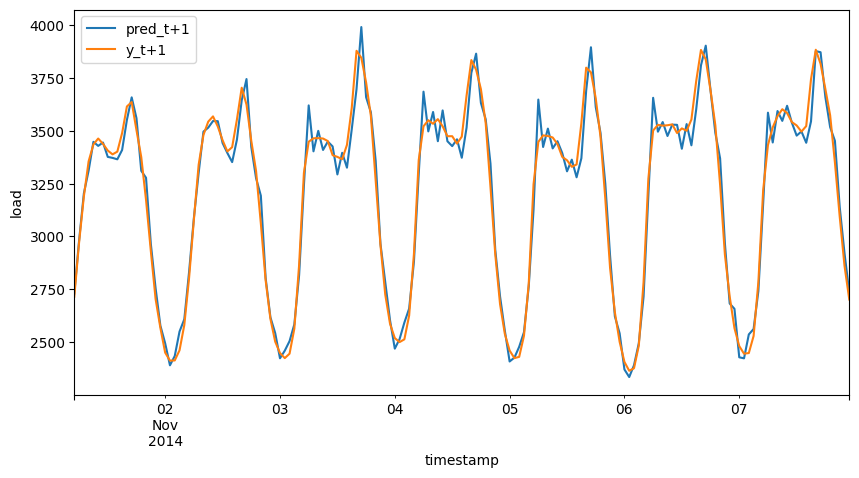

In [ ]:
# t+1
eval_df[eval_df["timestamp"] < "2014-11-08"].plot(x="timestamp",
                                                  y=["pred_t+1", "y_t+1"],
                                                  figsize=(10, 5))
plt.xlabel("timestamp")
plt.ylabel("load")
plt.show()

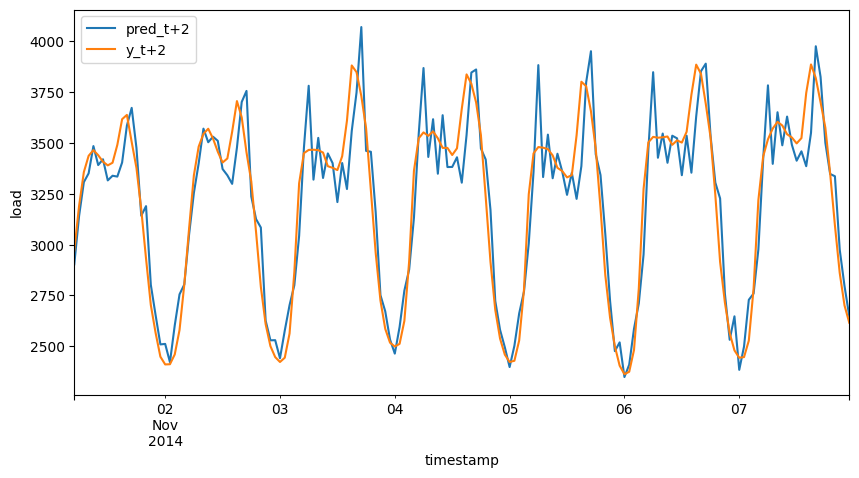

In [ ]:
# t+2
eval_df[eval_df["timestamp"] < "2014-11-08"].plot(x="timestamp",
                                                  y=["pred_t+2", "y_t+2"],
                                                  figsize=(10, 5))
plt.xlabel("timestamp")
plt.ylabel("load")
plt.show()

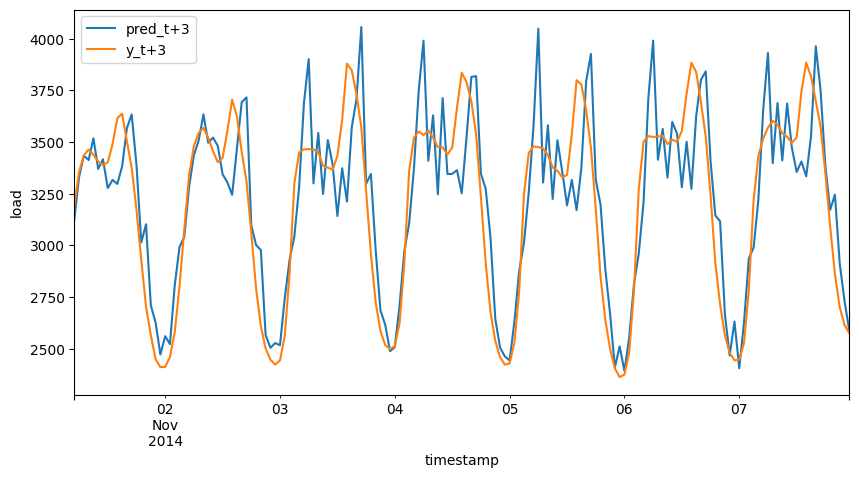

In [ ]:
# t+3
eval_df[eval_df["timestamp"] < "2014-11-08"].plot(x="timestamp",
                                                  y=["pred_t+3", "y_t+3"],
                                                  figsize=(10, 5))
plt.xlabel("timestamp")
plt.ylabel("load")
plt.show()

# LSTM을 이용한 다변수 / single step 예측
- load와 temp 속성을 모두 사용

In [4]:
# 데이터 불러오기 (소수점 2자리까지만 표시)
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

energy = pd.read_csv("./data/energy.csv")
energy.head()

,timestamp,load,temp
0,2012-01-01 00:00:00,"2,698.00",32.00
1,2012-01-01 01:00:00,"2,558.00",32.67
2,2012-01-01 02:00:00,"2,444.00",30.00
3,2012-01-01 03:00:00,"2,402.00",31.00
4,2012-01-01 04:00:00,"2,403.00",32.00


- timestamp를 문자열에서 datetime 타입으로 변경
- timestamp를 index로 설정

In [5]:
energy["timestamp"] = pd.to_datetime(energy["timestamp"])
energy.set_index("timestamp", inplace=True)
energy.head()

,load,temp
timestamp,,
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


- 훈련, 검증, 테스트 데이터 분리

In [11]:
val_start = "2014-09-01 00:00:00"
test_start = "2014-11-01 00:00:00"

train = energy[energy.index < val_start]
valid = energy[(energy.index >= val_start) & (energy.index < test_start)]
test = energy[energy.index >= test_start]

train.shape, valid.shape, test.shape

((23376, 2), (1464, 2), (1464, 2))

In [ ]:
train.head()

,load,temp
timestamp,,
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


- 시각화

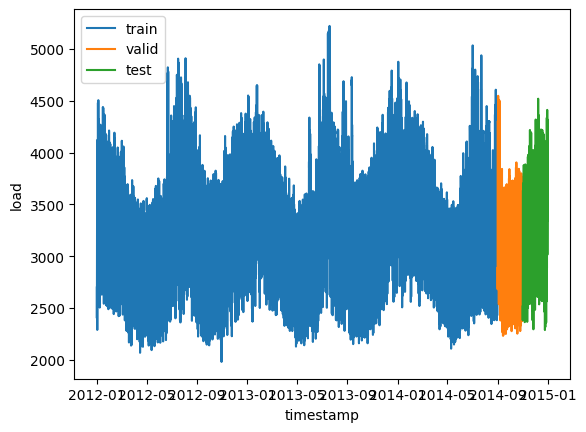

In [ ]:
# load
import matplotlib.pyplot as plt

plt.plot(train["load"], label="train")
plt.plot(valid["load"], label="valid")
plt.plot(test["load"], label="test")
plt.xlabel("timestamp")
plt.ylabel("load")
plt.legend()
plt.show()

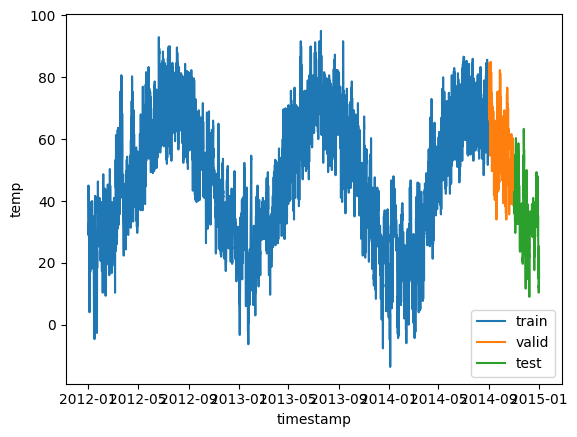

In [ ]:
# temp
plt.plot(train["temp"], label="train")
plt.plot(valid["temp"], label="valid")
plt.plot(test["temp"], label="test")
plt.xlabel("timestamp")
plt.ylabel("temp")
plt.legend()
plt.show()

- 스케일링

In [12]:
from sklearn.preprocessing import MinMaxScaler

# load만 복원하기 위한 스케일링 (먼저 해야함)
y_scaler = MinMaxScaler()
y_scaler.fit_transform(train[["load"]])

scaler = MinMaxScaler()

# load와 temp가 각각 크기로 스케일링
train[["load", "temp"]] = scaler.fit_transform(train)
valid[["load", "temp"]] = scaler.transform(valid)
test[["load", "temp"]] = scaler.transform(test)

train.head()

<ipython-input-12-83ca6cbf27a3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[["load", "temp"]] = scaler.fit_transform(train)
<ipython-input-12-83ca6cbf27a3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid[["load", "temp"]] = scaler.transform(valid)
<ipython-input-12-83ca6cbf27a3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

,load,temp
timestamp,,
2012-01-01 00:00:00,0.22,0.42
2012-01-01 01:00:00,0.18,0.43
2012-01-01 02:00:00,0.14,0.40
2012-01-01 03:00:00,0.13,0.41
2012-01-01 04:00:00,0.13,0.42


- 라벨데이터 (이후 1시간), 특성데이터 (이전 5시간) 분리하는 함수

In [ ]:
def split_data(data, T) :
  shifted = data.copy()

  # y_t+1 컬럼에 라벨데이터를 저장
  shifted["y_t+1"] = shifted["load"].shift(-1, freq="H")

  shifted_load = shifted.copy()
  shifted_temp = shifted.copy()

  # load, temp를 각각 이전 5시간 데이터를 특성데이터로 저장 (t-5, t-4, t-3, t-2, t-1, t-0)
  for t in range(1, T+1) :
    shifted_load[["t-{}".format(T-t)]] = shifted[["load"]].shift(T-t, freq="H")
    shifted_temp[["t-{}".format(T-t)]] = shifted[["temp"]].shift(T-t, freq="H")

  # load와 temp 부분만 자름 (timstamp, temp, load, load 6개 또는 temp 6개)
  shifted_load2 = shifted_load.iloc[:, 3:]
  shifted_temp2 = shifted_temp.iloc[:, 3:]

  temp = pd.concat([shifted.iloc[:, 2], shifted_load2, shifted_temp2],
                  axis=1, keys=["y", "load", "temp"])

  return temp

In [ ]:
T = 6

train_shifted = split_data(train, T)
train_shifted = train_shifted.dropna(how="any")

train_shifted.head()

y load                          temp                 \
                    y_t+1  t-5  t-4  t-3  t-2  t-1  t-0  t-5  t-4  t-3  t-2   
timestamp                                                                     
2012-01-01 05:00:00  0.18 0.22 0.18 0.14 0.13 0.13 0.15 0.42 0.43 0.40 0.41   
2012-01-01 06:00:00  0.23 0.18 0.14 0.13 0.13 0.15 0.18 0.43 0.40 0.41 0.42   
2012-01-01 07:00:00  0.29 0.14 0.13 0.13 0.15 0.18 0.23 0.40 0.41 0.42 0.41   
2012-01-01 08:00:00  0.35 0.13 0.13 0.15 0.18 0.23 0.29 0.41 0.42 0.41 0.40   
2012-01-01 09:00:00  0.37 0.13 0.15 0.18 0.23 0.29 0.35 0.42 0.41 0.40 0.39   

                               
                     t-1  t-0  
timestamp                      
2012-01-01 05:00:00 0.42 0.41  
2012-01-01 06:00:00 0.41 0.40  
2012-01-01 07:00:00 0.40 0.39  
2012-01-01 08:00:00 0.39 0.39  
2012-01-01 09:00:00 0.39 0.43

In [ ]:
valid_shifted = split_data(valid, T)
valid_shifted = valid_shifted.dropna(how="any")

valid_shifted.head()

y load                          temp                 \
                    y_t+1  t-5  t-4  t-3  t-2  t-1  t-0  t-5  t-4  t-3  t-2   
timestamp                                                                     
2014-09-01 05:00:00  0.28 0.28 0.24 0.22 0.22 0.22 0.24 0.78 0.77 0.76 0.75   
2014-09-01 06:00:00  0.34 0.24 0.22 0.22 0.22 0.24 0.28 0.77 0.76 0.75 0.75   
2014-09-01 07:00:00  0.44 0.22 0.22 0.22 0.24 0.28 0.34 0.76 0.75 0.75 0.75   
2014-09-01 08:00:00  0.54 0.22 0.22 0.24 0.28 0.34 0.44 0.75 0.75 0.75 0.75   
2014-09-01 09:00:00  0.60 0.22 0.24 0.28 0.34 0.44 0.54 0.75 0.75 0.75 0.75   

                               
                     t-1  t-0  
timestamp                      
2014-09-01 05:00:00 0.75 0.75  
2014-09-01 06:00:00 0.75 0.75  
2014-09-01 07:00:00 0.75 0.75  
2014-09-01 08:00:00 0.75 0.76  
2014-09-01 09:00:00 0.76 0.80

In [ ]:
test_shifted = split_data(test, T)
test_shifted = test_shifted.dropna(how="any")

test_shifted.head()

y load                          temp                 \
                    y_t+1  t-5  t-4  t-3  t-2  t-1  t-0  t-5  t-4  t-3  t-2   
timestamp                                                                     
2014-11-01 05:00:00  0.23 0.16 0.14 0.13 0.12 0.14 0.17 0.48 0.47 0.46 0.46   
2014-11-01 06:00:00  0.31 0.14 0.13 0.12 0.14 0.17 0.23 0.47 0.46 0.46 0.46   
2014-11-01 07:00:00  0.37 0.13 0.12 0.14 0.17 0.23 0.31 0.46 0.46 0.46 0.47   
2014-11-01 08:00:00  0.42 0.12 0.14 0.17 0.23 0.31 0.37 0.46 0.46 0.47 0.47   
2014-11-01 09:00:00  0.45 0.14 0.17 0.23 0.31 0.37 0.42 0.46 0.47 0.47 0.48   

                               
                     t-1  t-0  
timestamp                      
2014-11-01 05:00:00 0.46 0.47  
2014-11-01 06:00:00 0.47 0.47  
2014-11-01 07:00:00 0.47 0.48  
2014-11-01 08:00:00 0.48 0.48  
2014-11-01 09:00:00 0.48 0.51

- 특성/라벨 데이터 분리

In [ ]:
y_train = train_shifted.iloc[:, 0]
X_train = train_shifted.iloc[:, 1:]

y_valid = valid_shifted.iloc[:, 0]
X_valid = valid_shifted.iloc[:, 1:]

y_test = test_shifted.iloc[:, 0]
X_test = test_shifted.iloc[:, 1:]

y_train.shape, X_train.shape, y_valid.shape, X_valid.shape, y_test.shape, X_test.shape

((23370,), (23370, 12), (1458,), (1458, 12), (1458,), (1458, 12))

- 속성 차원을 추가 (12개의 속성으로 6개씩 2개로 분리)

In [ ]:
X_train = np.array(X_train).reshape(-1, 6, 2)
y_train = np.array(y_train).reshape(-1, 1)
X_valid = np.array(X_valid).reshape(-1, 6, 2)
y_valid = np.array(y_valid).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 6, 2)
y_test = np.array(y_test).reshape(-1, 1)

y_train.shape, X_train.shape, y_valid.shape, X_valid.shape, y_test.shape, X_test.shape

((23370, 1), (23370, 6, 2), (1458, 1), (1458, 6, 2), (1458, 1), (1458, 6, 2))

# 신경망 설계


<center><img src="https://arome1004.cafe24.com/images/time_series/lecture_image/one_step_RNN_multivariate_mutilayer.png" width=60%>
</center>


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint

model4 = Sequential()
model4.add(GRU(5, activation="tanh", return_sequences=True,
               input_shape=(T, 2)))
model4.add(GRU(4, activation="tanh"))
model4.add(Dense(1))

model4.compile(loss="mse", optimizer="adam")

In [ ]:
et = EarlyStopping(monitor="loss", mode="min", patience=10)
mc = ModelCheckpoint("./model/lstm3_model_{epoch:02d}_{loss:.3f}_{val_loss:.3f}.h5",
                     monitor="loss", mode="min",
                     save_best_only=True)

h4 = model4.fit(X_train, y_train, epochs=50, batch_size=32,
                validation_data=(X_valid, y_valid),
                callbacks=[et, mc])

Epoch 1/50
731/731 [==============================] - 14s 12ms/step - loss: 0.0245 - val_loss: 0.0148
Epoch 2/50
 15/731 [..............................] - ETA: 5s - loss: 0.0163

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


731/731 [==============================] - 8s 10ms/step - loss: 0.0069 - val_loss: 0.0030
Epoch 3/50
731/731 [==============================] - 6s 9ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 4/50
731/731 [==============================] - 9s 12ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 5/50
731/731 [==============================] - 13s 18ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 6/50
731/731 [==============================] - 7s 9ms/step - loss: 0.0015 - val_loss: 9.6370e-04
Epoch 7/50
731/731 [==============================] - 8s 11ms/step - loss: 0.0012 - val_loss: 9.3845e-04
Epoch 8/50
731/731 [==============================] - 9s 13ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/50
731/731 [==============================] - 11s 15ms/step - loss: 0.0010 - val_loss: 9.0793e-04
Epoch 10/50
731/731 [==============================] - 8s 11ms/step - loss: 9.9753e-04 - val_loss: 8.8072e-04
Epoch 11/50
731/731 [==============================] - 7s 9ms/step - loss: 9.8811

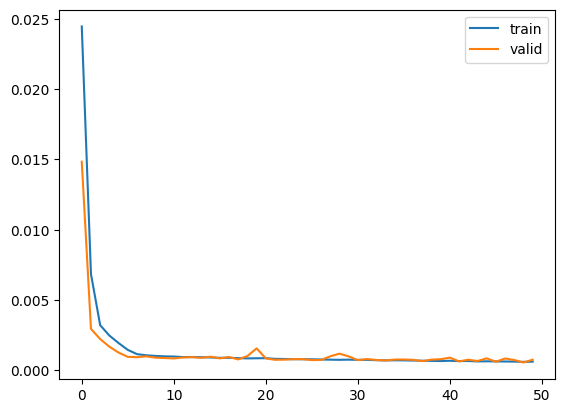

In [ ]:
# 시각화
plt.plot(h4.history["loss"], label="train")
plt.plot(h4.history["val_loss"], label="valid")
plt.legend()
plt.show()

# 예측

In [ ]:
# 모델 가져오기
model4.load_weights("./model/lstm3_model_49_0.001_0.001.h5")

In [ ]:
# 예측
pred = model4.predict(X_test)

pred

46/46 [==============================] - 0s 4ms/step


array([[0.24],
       [0.31],
       [0.39],
       ...,
       [0.51],
       [0.46],
       [0.42]], dtype=float32)

In [ ]:
eval_df = pd.DataFrame(pred, columns=["pred_t+1"])
eval_df['timestamp'] = test_shifted.index

eval_df = eval_df[['timestamp', "pred_t+1"]]

# y_test 추가
eval_df["actual"] = np.transpose(y_test).ravel()

eval_df.head()

,timestamp,pred_t+1,actual
0,2014-11-01 05:00:00,0.24,0.23
1,2014-11-01 06:00:00,0.31,0.31
2,2014-11-01 07:00:00,0.39,0.37
3,2014-11-01 08:00:00,0.42,0.42
4,2014-11-01 09:00:00,0.48,0.45


In [ ]:
# 역스케일링
eval_df[['pred_t+1']] = y_scaler.inverse_transform(eval_df[['pred_t+1']])
eval_df[['actual']] = y_scaler.inverse_transform(eval_df[['actual']])

eval_df.head()

,timestamp,pred_t+1,actual
0,2014-11-01 05:00:00,0.24,0.23
1,2014-11-01 06:00:00,0.31,0.31
2,2014-11-01 07:00:00,0.39,0.37
3,2014-11-01 08:00:00,0.42,0.42
4,2014-11-01 09:00:00,0.48,0.45


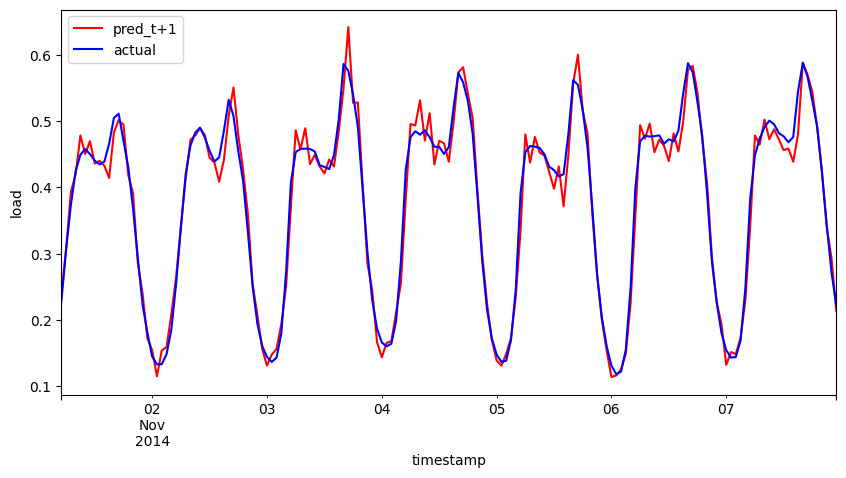

In [ ]:
eval_df[eval_df["timestamp"]<'2014-11-08'].plot(x='timestamp',
                                             y=['pred_t+1', 'actual'],
                                             style=['r', 'b'], figsize=(10, 5))
plt.xlabel('timestamp', fontsize=10)
plt.ylabel('load', fontsize=10)
plt.show()

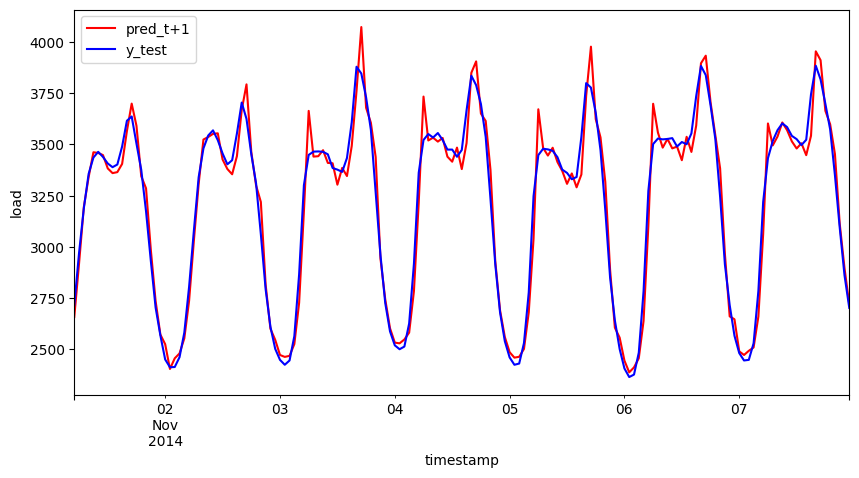